In [1]:
import numpy as np
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import cv2
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from scipy import stats

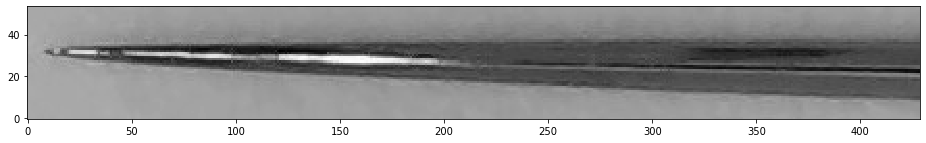

In [2]:
num = 9
image = Image.open(f'needlepictures/pic{num}.jpg').convert('L') # .convert to greyscale
plt.figure(figsize=(16,3))
plt.imshow(image,cmap = 'gray',origin='lower')
plt.show()

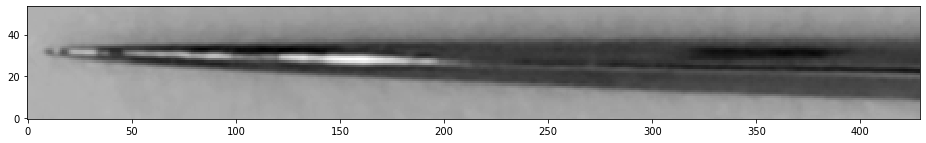

In [3]:
image = image.filter(ImageFilter.GaussianBlur(radius = 1))
plt.figure(figsize=(16,3))
plt.imshow(image,cmap = 'gray',origin='lower')
plt.show()

In [4]:
image = np.array(image)

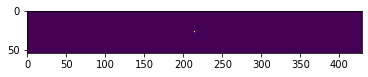

In [5]:
fft_image = np.fft.fft2(image)
fft_image = np.fft.fftshift(fft_image)
#plt.imshow(20*np.log10(np.abs(fft_image)))
plt.imshow(np.abs(fft_image))
plt.show()

In [6]:
# now we will define various masks for the image in fourier domain
def circular_mask_HP(image,radius):
    '''
    image: the numpy array for which circular filter is desired
    radius: radius of circle in pixels for filtering
    '''
    xlen, ylen = image.shape
    x_center = int(xlen/2)
    y_center = int(ylen/2)
    X,Y = np.meshgrid(range(xlen),range(ylen),indexing='ij')
    Z = np.ones([xlen,ylen])
    Z[ np.sqrt((X-x_center)**2 + (Y-y_center)**2) < radius  ] = 0
    return Z

def circular_mask_LP(image,radius):
    '''
    image: the numpy array for which circular filter is desired
    radius: radius of circle in pixels for filtering
    '''
    xlen, ylen = image.shape
    x_center = int(xlen/2)
    y_center = int(ylen/2)
    X,Y = np.meshgrid(range(xlen),range(ylen),indexing='ij')
    Z = np.zeros([xlen,ylen])
    Z[ np.sqrt((X-x_center)**2 + (Y-y_center)**2) < radius  ] = 1
    return Z

def rect_mask_HP(image,s1,s2):
    '''
    image: the numpy array for which circular filter is desired
    radius: radius of circle in pixels for filtering
    '''
    xlen, ylen = image.shape
    x_center = int(xlen/2)
    y_center = int(ylen/2)
    X,Y = np.meshgrid(range(xlen),range(ylen),indexing='ij')
    Z = np.ones([xlen,ylen])
    Z[ (np.abs(X-x_center) < s1) & (np.abs(Y-y_center) < s2)] = 0
    return Z

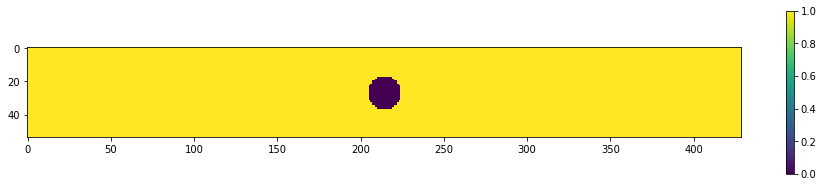

In [7]:
plt.figure(figsize=(16,3))
plt.imshow(circular_mask_HP(image,10))
plt.colorbar()
plt.show()

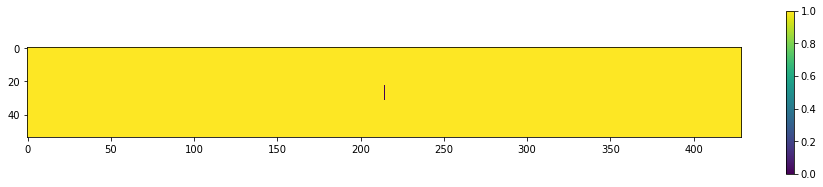

In [8]:
plt.figure(figsize=(16,3))
plt.imshow(rect_mask_HP(image,5,1))
plt.colorbar()
plt.show()

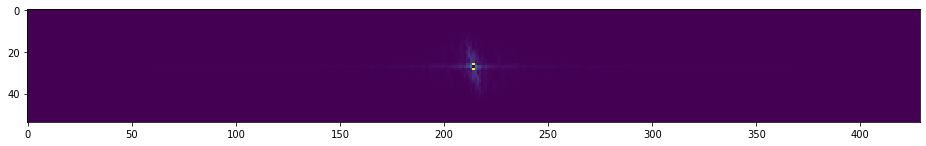

In [9]:
fftmask_image = fft_image*circular_mask_HP(fft_image,radius=1)
#fftmask_image = fft_image*rect_mask_HP(fft_image,5,1)
plt.figure(figsize=(16,3))
plt.imshow(np.abs(fftmask_image))
plt.show()

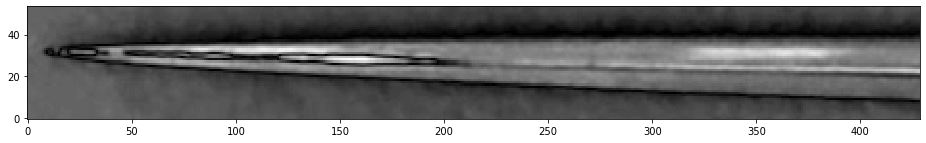

In [10]:
ifft_shift_image = np.fft.ifftshift(fftmask_image)
filtered_image = np.fft.ifft2(ifft_shift_image)
filtered_image = np.abs(filtered_image)
plt.figure(figsize=(16,3))
plt.imshow(filtered_image,cmap = 'gray',origin='lower')
plt.show()

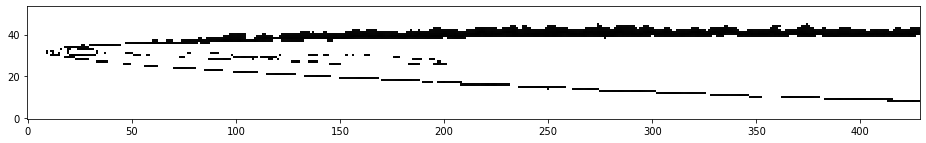

In [11]:
filtered_image[filtered_image>9] = 255
plt.figure(figsize=(16,3))
plt.imshow(filtered_image,cmap = 'gray',origin='lower')
#plt.colorbar()
plt.show()

In [12]:
c1=[]
c2=[]
index_list=[]
diff = []
for i in range(filtered_image.shape[1]):
    peaks,_ = find_peaks(-filtered_image[:,i])
    if i < 400:# index upto which boundry detection is good
        if (len(peaks) == 1) and len(index_list) == 0:
            c1.append(peaks[0])
            c2.append(peaks[0])
            index_list.append(i)
            diff.append(0)

        if (len(peaks) == 2) and len(index_list) == 0:
            c1.append(peaks[0])
            c2.append(peaks[-1])
            index_list.append(i)
            diff.append(peaks[-1] - peaks[0])

        if len(peaks) in [2,4] and len(index_list) != 0:
            if (peaks[-1] - peaks[0]) > diff[-1]:
                c1.append(peaks[0])
                c2.append(peaks[-1])
                index_list.append(i)
                diff.append(peaks[-1] - peaks[0])
c1 = np.array(c1)
c2 = np.array(c2)
index_list = np.array(index_list)

R^2 =  0.9978710074478455


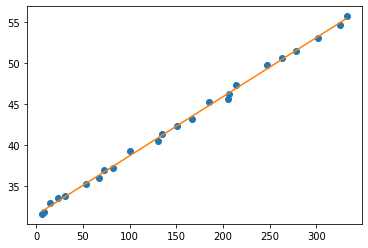

In [13]:
# Calculating R2 value after rotating the centerline
x = index_list
y = (c1+c2)/2
deg = 1/360 * np.pi
theta = -10*deg
x_rot = x*np.cos(theta) + y*np.sin(theta)
y_rot = -x*np.sin(theta) + y*np.cos(theta)
res = stats.linregress(x_rot,y_rot)
print('R^2 = ',res.rvalue**2)
plt.plot(x_rot,y_rot,'o')
plt.plot(x_rot,res.intercept + res.slope*x_rot)

In [14]:
res

LinregressResult(slope=0.07176614194986003, intercept=31.554228850295416, rvalue=0.9989349365438399, pvalue=6.857013638579093e-31, stderr=0.0007067374873394732)

In [15]:
# Calculating R2 value from raw data
res = stats.linregress(index_list,(c1+c2)/2)
#print('R^2 = ',res.rvalue**2)

In [16]:
res

LinregressResult(slope=-0.01562346944818882, intercept=31.476979048374595, rvalue=-0.9784289173475348, pvalue=1.4675029759716973e-16, stderr=0.0007032877605430537)

In [17]:
conv_size=15
res = stats.linregress(index_list,(savgol_filter(c1,conv_size,4)+savgol_filter(c2,conv_size,4))/2)
#res = stats.linregress(index_list,(c1+c2)/2)

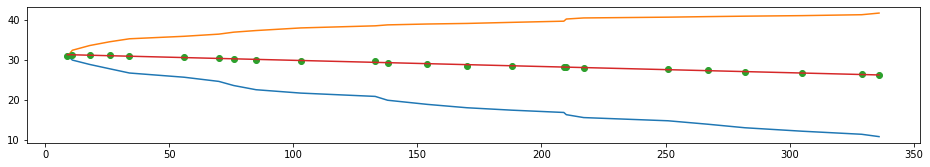

In [18]:
conv_size=15
plt.figure(figsize=(16,2.5))
plt.plot(index_list,savgol_filter(c1,conv_size,4))
plt.plot(index_list,savgol_filter(c2,conv_size,4))
plt.plot(index_list,(savgol_filter(c1,conv_size,4)+savgol_filter(c2,conv_size,4))/2,"o")
plt.plot(index_list,res.intercept + res.slope*index_list)
plt.show()

In [19]:
# best looking picture is 3, i<400, conv_size=15
if num ==3:
    image = Image.open(f'needlepictures/pic{num}.jpg') # .convert to greyscale
    plt.figure(figsize=(16,3))
    plt.rc('legend', fontsize=14)
    #plt.title('Needle centerline extraction')
    plt.imshow(image,origin='lower')
    plt.plot(index_list,savgol_filter(c1,conv_size,4),'^',label = 'Detected boundary points',linewidth=2,color='blue')
    #plt.plot(index_list,savgol_filter(c1,conv_size,4),'--',label = 'Boundary',linewidth=2,color='blue')
    plt.plot(index_list,savgol_filter(c2,conv_size,4),'^',linewidth=2,color='blue')
    plt.plot(index_list,(savgol_filter(c1,conv_size,4)+savgol_filter(c2,conv_size,4))/2,"o",label='Detected center points',\
             color='red')
    plt.plot(index_list,res.intercept + res.slope*index_list,label='Line fit to center points',linewidth=2,color='red')
    plt.legend(loc='center right')
    plt.xticks([])
    plt.yticks([])
    #plt.savefig('centerline_detection.svg')
    plt.show()

In [22]:
r_sq_list = [0.9960540187342157, 0.9986332288174028, 0.9962645943172125, 0.9954639175312552, 
0.9985495139522136, 0.9983596159050288, 0.997130932582143, 0.9941862076951766, 0.9978710074478455]

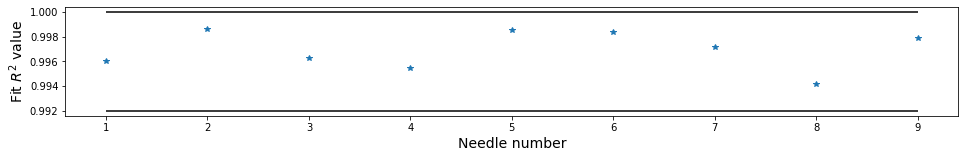

In [27]:
plt.figure(figsize=(16,2))
plt.plot(range(1,len(r_sq_list)+1),r_sq_list,'*')
plt.xticks(range(1,len(r_sq_list)+1))
plt.ylabel('Fit $R^2$ value',fontsize =14)
plt.xlabel('Needle number',fontsize =14)
plt.hlines(0.992,1,9)
plt.hlines(1,1,9)
plt.savefig('R2fit_straightness.svg')
plt.show()